### Project Defintion

In [6]:
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

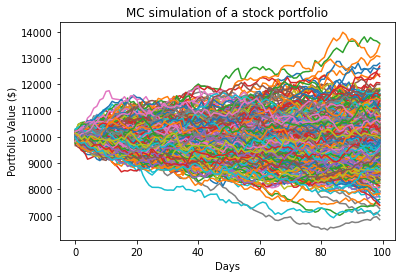

In [33]:
def get_data(stocks, start, end): 
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData["Close"] # eod data
    returns = stockData.pct_change() # dela between the t1 + t2 eod stock prices
    meanReturns = returns.cov() # mean of delta
    covMatrix = returns.cov() # covariance used to determine a measure of the joint variabiity of two random variabels
    return meanReturns, covMatrix

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

weights = np.random.random(len(meanReturns)) # random weights array
weights /= np.sum(weights) # normalise weights

# monte carlo method
mc_sims = 400 # num of simultions
T = 100 # analysis timeframe

meanM = np.full(shape=(T, len(weights)), fill_value=0.0)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims): 
    Z = np.random.normal(size=(T, len(weights))) # uncorrelated random variables (RVs)
    L = np.linalg.cholesky(covMatrix) # cholskey decompositon to lower trangular matrix , select lower end of data matrix
    # cholskey method is used to simulate system with mutiple correlated vaiables
    dailyReturns = meanM + np.inner(L, Z) # correlated daily returns for each stock in portfolio
    portfolio_sims[:, m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio # cumprod - cumilative
    

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()


In [34]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
        
        
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR_5 ${}'.format(round(VaR,2)))
print('CVaR_5 ${}'.format(round(CVaR,2)))

VaR_5 $1903.84
CVaR_5 $2358.37


In [35]:
# initial derivative parameters 
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility 
r = 0.01            #risk-free rate 
N = 10              #number of time steps
M = 1000            #number of simulations
market_value = 3.86 #market price of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years
print(T)

0.1643835616438356


### Discritization Solution 

In [40]:
# Precompute constants
dt = T/N # time in years / number of time steps 
nudt = (r - 0.5*vol**2)*dt # driff term - half of volatility squared * dt
volsdt = vol*np.sqrt(dt) # volatiity standard deviation 
lnS = np.log(S) # logorithm of s

# Standard Error Placeholders
sum_CT = 0 # used to compute the simulation error
sum_CT2 = 0

# Monte Carlo Method 
for i in range(M):
    lnSt = lnS # intials log
    for j in range(N): # take time step through the time steps
        lnSt = lnSt + nudt + volsdt*np.random.normal() # calculate the next logS variable
        # logS + driff term + vol squared * random variable (thats by default 0 with variance of 1)
        # this will cotinue until Nth step is reached
    
    ST = np.exp(lnSt) # stockprice as a exponential of natural logorithm
    CT = max(0, ST - K) # looking at max of stock price - strike price
    sum_CT = sum_CT + CT # add previous CT to current CT
    sum_CT2 = sum_CT2 + CT*CT 

# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M # discount factor * sum_CT / number of simulations
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
# standard deviation (monte carlo method) 
# discounting squared factor which came in with exponenet
# M-1 is used because of denominator in the standard deviation processes
SE = sigma/np.sqrt(M) # sigma normalised by squared root of number of simulations

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))
# the result is random because we simulate random variables through the simulation

Call value is $3.82 with SE +/- 0.11


### Vectorized Solution

In [39]:
#precompute constants
dt = T/N # time in years / number of time steps 
nudt = (r - 0.5*vol**2)*dt # driff term = risk free rate - half of volatility squared * dt
volsdt = vol*np.sqrt(dt) # volatiity standard deviation 
lnS = np.log(S) # logorithm of s

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) # monte carlo matrix of size (time steps, number of simulations)
delta_lnSt = nudt + volsdt*Z # creating a new, delta of matrix driff terms * volatility standard deviation * size of matrix
lnSt = lnS + np.cumsum(delta_lnSt, axis=0) # cumilative changes of the paths + original logorithm 
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) ) # compute the matrix 

# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.82 with SE +/- 0.11


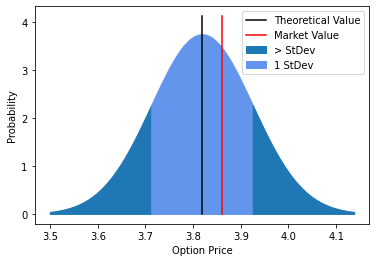

In [42]:
# compuated theoretical value by using Monte Carlo Simulations which used implied volatility 
# the implied volatility was at different strike, that was used because a traded instrument,
# we took a strike closer to what is stands today and compared to where market maker is makig its bid.
# model shows a predected price to be within 1 standard deviation of market price

x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()